# Batch runを走らせよう

モデルを走らせなければいけない回数は
$$
    {試したい値の数} ^ {(興味があるパラメータ数)} * {走らせたいrun(タイムステップ)数}
$$
と、<b>次元の呪い（curse of dimensionality）に陥る</b>(指数関数的に増えていく)ので注意！

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random

# ==== 以下、質問文で示されている関数を流用 ====

def count_same_color_neighbors(grid, x, y, n, tolerance):
    color = grid[x, y]
    if color is None:
        return 0, 0
    same_color_count = 0
    agent_count = 0
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx = (x + dx) % n
            ny = (y + dy) % n
            neighbor_color = grid[nx, ny]
            if neighbor_color is not None:
                agent_count += 1
                if neighbor_color == color:
                    same_color_count += 1
    return same_color_count, agent_count

def find_empty_neighbors(grid, x, y, n):
    empty_positions = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx = (x + dx) % n
            ny = (y + dy) % n
            if grid[nx, ny] is None:
                empty_positions.append((nx, ny))
    return empty_positions

def step(grid, n, tolerance):
    """
    1ステップ進める。
    neighbor_rate(同色近隣数/8) < tolerance のエージェントが
    見つけた空きマスにランダム移動。
    """
    new_grid = grid.copy()
    moves = []
    for x in range(n):
        for y in range(n):
            if grid[x, y] is None:
                continue
            same_color_count, agent_count_8 = count_same_color_neighbors(grid, x, y, n, tolerance)
            neighbor_rate = same_color_count / 8
            if neighbor_rate < tolerance:
                empty_positions = find_empty_neighbors(grid, x, y, n)
                if len(empty_positions) > 0:
                    new_pos = random.choice(empty_positions)
                    moves.append((x, y, new_pos[0], new_pos[1]))

    # 移動をまとめて適用
    random.shuffle(moves)
    for x, y, nx, ny in moves:
        c = grid[x, y]
        # まだ移動していなければ実行
        if new_grid[x, y] == c and new_grid[nx, ny] is None:
            new_grid[x, y] = None
            new_grid[nx, ny] = c
    return new_grid

def compute_metrics(grid, n, tolerance):
    """
    grid上の全エージェントについて
      same_color_neighbors / 8 を算出し平均する。
    """
    total_neighbor_rate = 0.0
    agent_count = 0
    for x in range(n):
        for y in range(n):
            c = grid[x, y]
            if c is not None:
                same_color_count, agent_count = count_same_color_neighbors(grid, x, y, n, tolerance)
                nr = (same_color_count+1) / 8
                total_neighbor_rate += nr
                agent_count += 1
    if agent_count == 0:
        return 0.0
    else:
        return total_neighbor_rate / agent_count


# ==== ここから実験コード ====

def initialize_grid(n, empty_rate):
    """
    グリッド(n x n)を初期化。
    - empty_rateの割合がNone(=空き)
    - 残りを 2色(0, 1) で半々に配置
    """
    total_cells = n * n
    num_empty = int(total_cells * empty_rate)
    num_agents = total_cells - num_empty
    num_color0 = num_agents // 2
    num_color1 = num_agents - num_color0

    # 中身をリスト化し、シャッフル後に n x n の配列に再整形
    cell_list = [None]*num_empty + [0]*num_color0 + [1]*num_color1
    random.shuffle(cell_list)

    grid = np.array(cell_list).reshape(n, n)
    return grid

def run_one_experiment(n, tolerance, empty_rate, num_timesteps=100):
    """
    与えられたパラメータで1回分の実験を走らせる。
    各ステップのaverage_similarityをリストで返す。
    """
    # 初期化
    grid = initialize_grid(n, empty_rate)
    similarity_history = []
    # 各ステップで計測
    for t in range(num_timesteps+1):
        # t=0(初期状態)の計測も含めるならnum_timesteps+1にしておく
        avg_sim = compute_metrics(grid, n, tolerance)
        similarity_history.append(avg_sim)
        if t < num_timesteps:
            # 次ステップへ
            grid = step(grid, n, tolerance)
    return similarity_history



In [ ]:

# =============== 実験パラメータ ===============
n = 7               # グリッドサイズ (必要に応じて調整)
num_timesteps = 100  # シミュレーションする最大ステップ数
num_runs = 100       # 各条件下で何回繰り返すか
# =============== 実験パラメータ ===============

tolerance_list = np.arange(0.1, 0.71, 0.05)  # 0.1～0.7を0.05刻み
empty_rate_list = np.arange(0.1, 1.0, 0.1)  # 0.1～0.9を0.1刻み

# 結果格納用
# key: (tolerance, empty_rate), value: shape=(num_runs, num_timesteps+1) でsimilarityを記録
results = {}

# 実行時間が長くなるので注意(13×9×100×100ステップ)。
# 以下、実際に回す場合は相応に時間がかかります。
for er in empty_rate_list:
    for tol in tolerance_list:
        # 100回実験し、各ステップのsimilarityを集める
        all_runs_history = []
        for r in range(num_runs):
            sim_hist = run_one_experiment(n, tol, er, num_timesteps=num_timesteps)
            all_runs_history.append(sim_hist)
        # shape=(num_runs, num_timesteps+1) の2次元配列になるイメージ
        results[(tol, er)] = np.array(all_runs_history)



In [ ]:
# =============== グラフ描画 ===============
# 取り出すステップ (1, 5, 100)
timesteps_to_plot = [1, 5, 100]

# 3つのサブプロットを並べる例
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, t_ in enumerate(timesteps_to_plot):
    ax = axes[i]
    for er in empty_rate_list:
        y_values = []
        for tol in tolerance_list:
            # 結果を取り出して、 t_ステップ目のaverage_similarity を num_runsぶん平均
            sim_array = results[(tol, er)]  # shape=(num_runs, num_timesteps+1)
            avg_sim_t = np.mean(sim_array[:, t_])  # t_ステップ目を平均
            y_values.append(avg_sim_t)

        ax.plot(tolerance_list, y_values, marker='o', label=f"empty={er:.1f}")

    ax.set_title(f"Time={t_}")
    ax.set_xlabel("Tolerance")
    ax.set_ylim(0, 1)  # similarityは0～1の範囲想定
    if i == 0:
        ax.set_ylabel("Average Similarity")

# 凡例はまとめて右上などに出す
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 自身もカウントに含めている？

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random

# ==== 以下、質問文で示されている関数を流用 ====

def count_same_color_neighbors_including_self(grid, x, y, n):
    """
    grid[x, y] のエージェントと同じ色のエージェントが、
    「自分を含む3×3の領域(トーラス状)」に何人いるか数える関数。
    さらに、3×3のうち実際にエージェントが存在する数（Noneでない数）も返す。
    
    例:
      - 自分だけしかいない場合 => same_color_count=1, agent_count_9=1
      - 自分＋違う色が1人 => same_color_count=1, agent_count_9=2
      - 自分＋同じ色2人 => same_color_count=3, agent_count_9=3
      など
    """
    color = grid[x, y]
    if color is None:
        return 0, 0

    same_color_count = 0
    agent_count_9 = 0

    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx = (x + dx) % n
            ny = (y + dy) % n
            neighbor_color = grid[nx, ny]
            if neighbor_color is not None:
                agent_count_9 += 1
                if neighbor_color == color:
                    same_color_count += 1

    return same_color_count, agent_count_9

def find_empty_neighbors(grid, x, y, n):
    empty_positions = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            nx = (x + dx) % n
            ny = (y + dy) % n
            if grid[nx, ny] is None:
                empty_positions.append((nx, ny))
    return empty_positions

def step(grid, n, tolerance):
    """
    1ステップ進める。
    neighbor_rate = (same_color_count / agent_count_9) が tolerance 未満なら
    見つけた空きマスにランダム移動。
    """
    new_grid = grid.copy()
    moves = []
    for x in range(n):
        for y in range(n):
            if grid[x, y] is None:
                continue

            same_color_count, agent_count_9 = count_same_color_neighbors_including_self(grid, x, y, n)
            if agent_count_9 > 0:
                neighbor_rate = same_color_count / agent_count_9
            else:
                neighbor_rate = 0  # 通常ここには来ない

            if neighbor_rate < tolerance:
                empty_positions = find_empty_neighbors(grid, x, y, n)
                if len(empty_positions) > 0:
                    new_pos = random.choice(empty_positions)
                    moves.append((x, y, new_pos[0], new_pos[1]))

    # 移動をまとめて適用
    random.shuffle(moves)
    for x, y, nx, ny in moves:
        c = grid[x, y]
        # まだ移動していなければ実行
        if new_grid[x, y] == c and new_grid[nx, ny] is None:
            new_grid[x, y] = None
            new_grid[nx, ny] = c
    return new_grid

def compute_metrics(grid, n, tolerance):
    """
    grid上の全エージェントについて、
      neighbor_rate = same_color_count / agent_count_9
    の平均値を返す。
    """
    total_neighbor_rate = 0.0
    count_agents = 0

    for x in range(n):
        for y in range(n):
            if grid[x, y] is not None:
                same_color_count, agent_count_9 = count_same_color_neighbors_including_self(grid, x, y, n)
                # もしも agent_count_9=0 になることは普通は無いはずだが、一応チェック
                if agent_count_9 > 0:
                    nr = same_color_count / agent_count_9
                else:
                    nr = 0
                total_neighbor_rate += nr
                count_agents += 1

    if count_agents == 0:
        return 0.0
    else:
        return total_neighbor_rate / count_agents



# ==== ここから実験コード ====

def initialize_grid(n, empty_rate):
    """
    グリッド(n x n)を初期化。
    - empty_rateの割合がNone(=空き)
    - 残りを 2色(0, 1) で半々に配置
    """
    total_cells = n * n
    num_empty = int(total_cells * empty_rate)
    num_agents = total_cells - num_empty
    num_color0 = num_agents // 2
    num_color1 = num_agents - num_color0

    # 中身をリスト化し、シャッフル後に n x n の配列に再整形
    cell_list = [None]*num_empty + [0]*num_color0 + [1]*num_color1
    random.shuffle(cell_list)

    grid = np.array(cell_list).reshape(n, n)
    return grid

def run_one_experiment(n, tolerance, empty_rate, num_timesteps=100):
    """
    与えられたパラメータで1回分の実験を走らせる。
    各ステップのaverage_similarityをリストで返す。
    """
    # 初期化
    grid = initialize_grid(n, empty_rate)
    similarity_history = []
    # 各ステップで計測
    for t in range(num_timesteps+1):
        # t=0(初期状態)の計測も含めるならnum_timesteps+1にしておく
        avg_sim = compute_metrics(grid, n, tolerance)
        similarity_history.append(avg_sim)
        if t < num_timesteps:
            # 次ステップへ
            grid = step(grid, n, tolerance)
    return similarity_history



In [14]:

# =============== 実験パラメータ ===============
n = 7               # グリッドサイズ (必要に応じて調整)
num_timesteps = 500  # シミュレーションする最大ステップ数
num_runs = 100       # 各条件下で何回繰り返すか
# =============== 実験パラメータ ===============

tolerance_list = np.arange(0.1, 0.71, 0.05)  # 0.1～0.7を0.05刻み
empty_rate_list = np.arange(0.1, 1.0, 0.1)  # 0.1～0.9を0.1刻み

# 結果格納用
# key: (tolerance, empty_rate), value: shape=(num_runs, num_timesteps+1) でsimilarityを記録
results = {}

# 実行時間が長くなるので注意(13×9×100×100ステップ)。
# 以下、実際に回す場合は相応に時間がかかります。
for er in empty_rate_list:
    for tol in tolerance_list:
        # 100回実験し、各ステップのsimilarityを集める
        all_runs_history = []
        for r in range(num_runs):
            sim_hist = run_one_experiment(n, tol, er, num_timesteps=num_timesteps)
            all_runs_history.append(sim_hist)
        # shape=(num_runs, num_timesteps+1) の2次元配列になるイメージ
        results[(tol, er)] = np.array(all_runs_history)



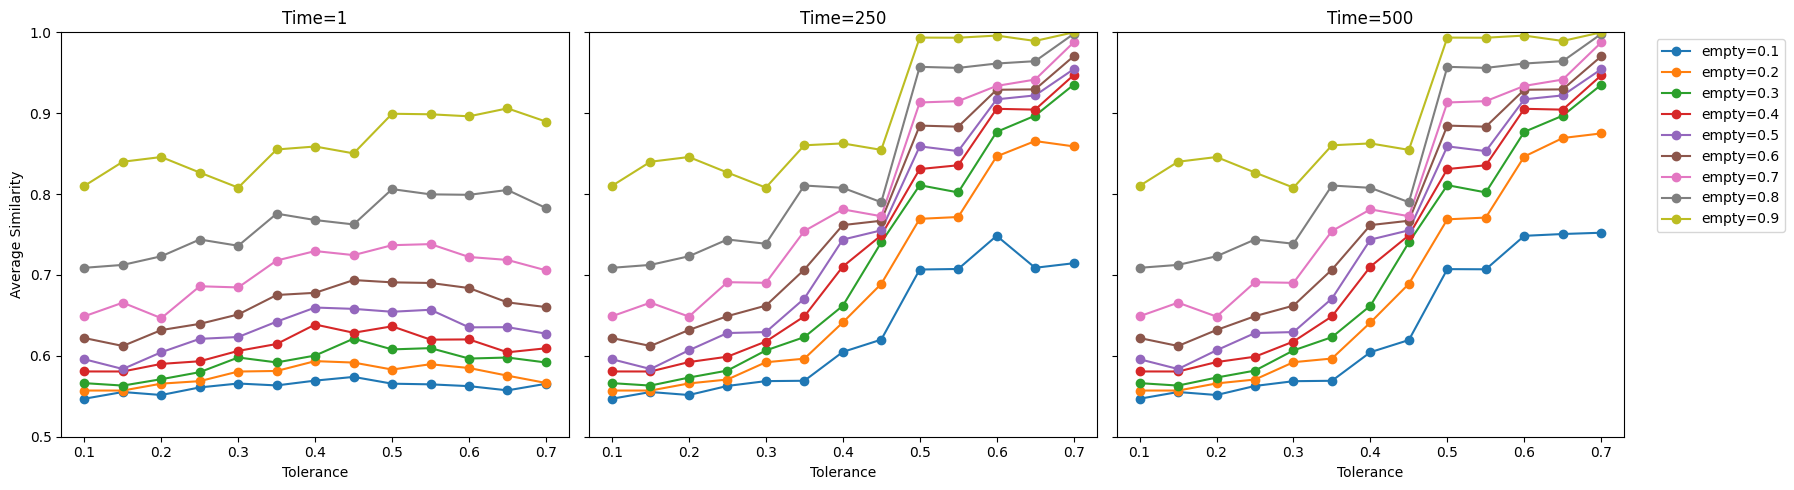

In [15]:
# =============== グラフ描画 ===============
# 取り出すステップ (1, 5, 100)
timesteps_to_plot = [1, 250, 500]

# 3つのサブプロットを並べる例
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, t_ in enumerate(timesteps_to_plot):
    ax = axes[i]
    for er in empty_rate_list:
        y_values = []
        for tol in tolerance_list:
            # 結果を取り出して、 t_ステップ目のaverage_similarity を num_runsぶん平均
            sim_array = results[(tol, er)]  # shape=(num_runs, num_timesteps+1)
            avg_sim_t = np.mean(sim_array[:, t_])  # t_ステップ目を平均
            y_values.append(avg_sim_t)

        ax.plot(tolerance_list, y_values, marker='o', label=f"empty={er:.1f}")

    ax.set_title(f"Time={t_}")
    ax.set_xlabel("Tolerance")
    ax.set_ylim(0.5, 1)  # similarityは0～1の範囲想定
    if i == 0:
        ax.set_ylabel("Average Similarity")

# 凡例はまとめて右上などに出す
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()